# What is segmentation in deep learning?
Image result for binary segmentation in deep learning
Image segmentation is the task of clustering parts of an image together that belong to the same object class. This process is also called pixel-level classification.
In other words, it involves partitioning images (or video frames) into multiple segments or objects.In binary segmentation there exists two class of object. One object should be detect from others.

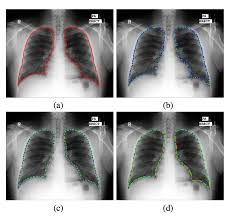


# Importung requied libraires

In [1]:

import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from skimage import measure

In [2]:
DIR="../input/chest-xray-masks-and-labels"
lung_image_paths=glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths=glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))

In [3]:
related_paths=defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)
            
            
            
paths_df = pd.DataFrame.from_dict(related_paths)

In [4]:
DIR = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/"

covid_image_paths = glob(os.path.join(DIR,"images/*.png"))

related_paths = defaultdict(list)

for covid_path in covid_image_paths:
    covid_match = re.search("COVID/(.*)\.png$", covid_path)
    if covid_match:
        covid_name = covid_match.group(1)
        related_paths["covid_path"].append(covid_path)
        
        
paths_dfc = pd.DataFrame.from_dict(related_paths)

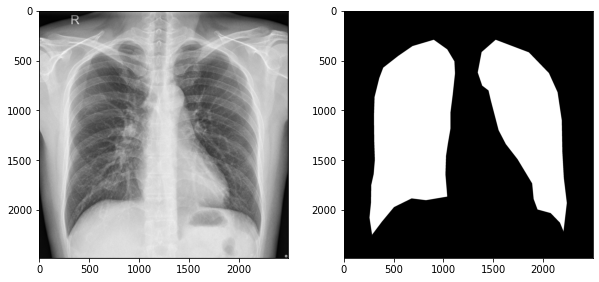

In [5]:
xray_num = 9
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

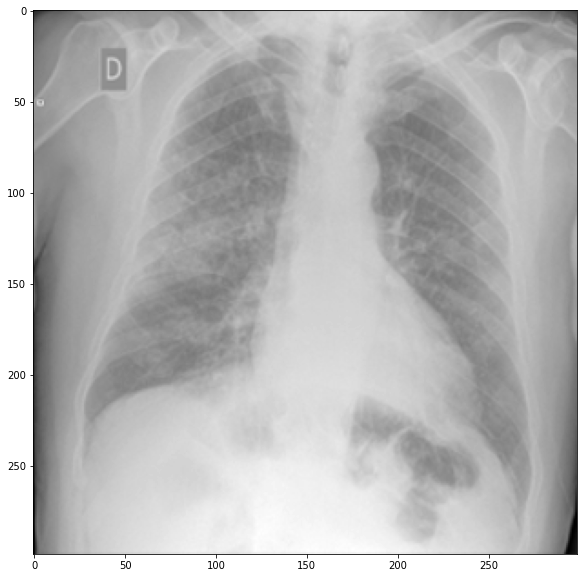

In [6]:
xray_num = 9
covid_path = paths_dfc["covid_path"][xray_num]


img = PIL.Image.open(covid_path)


fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(1,1,1)
ax1.imshow(img, cmap = "gray")

In [7]:
import cv2
from tqdm import tqdm

In [8]:
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)
  
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array
img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")

100%|██████████| 704/704 [00:54<00:00, 12.87it/s]


In [9]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size)

# What is U-net ?

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg.[1] The network is based on the fully convolutional network[2] and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.

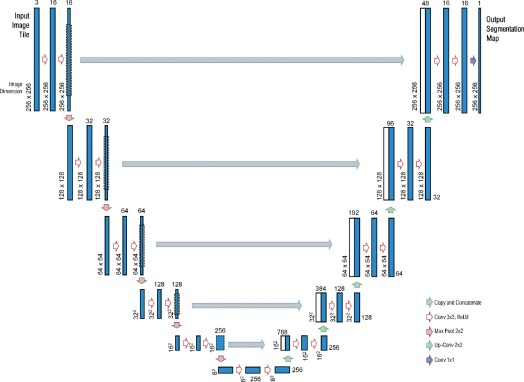

In [10]:
### U-net 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
   
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

# Model creation and compiling 

In [11]:
from tensorflow.keras.optimizers import Adam
EPOCHS = 10
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=5*1e-4), loss="binary_crossentropy", \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', #verbose=1, 
                             save_best_only=True, #mode='min', 
                             save_weights_only = True)


early = EarlyStopping(monitor="loss", 
                      #mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early]

# Fitting the model 

In [13]:
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 30, 
                    batch_size = 16,
                   callbacks = callbacks_list)
model.save('my_model.h5')

Epoch 1/30
36/36 [==============================] - 18s 209ms/step - loss: 0.5747 - dice_coef: 0.2837 - binary_accuracy: 0.7458 - val_loss: 0.5363 - val_dice_coef: 0.2794 - val_binary_accuracy: 0.7454
Epoch 2/30
36/36 [==============================] - 5s 135ms/step - loss: 0.5685 - dice_coef: 0.2964 - binary_accuracy: 0.7464 - val_loss: 0.4904 - val_dice_coef: 0.3095 - val_binary_accuracy: 0.7454
Epoch 3/30
36/36 [==============================] - 5s 135ms/step - loss: 0.4663 - dice_coef: 0.3334 - binary_accuracy: 0.7463 - val_loss: 0.4283 - val_dice_coef: 0.3734 - val_binary_accuracy: 0.7454
Epoch 4/30
36/36 [==============================] - 5s 135ms/step - loss: 0.3735 - dice_coef: 0.4446 - binary_accuracy: 0.7608 - val_loss: 0.2417 - val_dice_coef: 0.6862 - val_binary_accuracy: 0.9085
Epoch 5/30
36/36 [==============================] - 5s 135ms/step - loss: 0.1843 - dice_coef: 0.7858 - binary_accuracy: 0.9297 - val_loss: 0.1359 - val_dice_coef: 0.8415 - val_binary_accuracy: 0.9460

# Save the model so that later we we could use without further training

In [14]:
model.save('my_model.h5') 


0.919941811714014

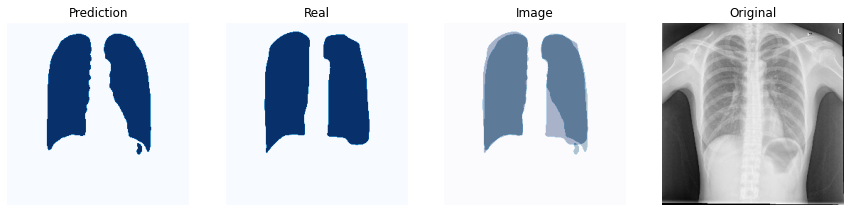

In [15]:
def test_on_image(model, img_array, img_num, img_side_size = 256):
    
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Prediction")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Real");
    plt.axis("off")
    
    plt.subplot(1,4,3)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")
    
    return pred
def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

IMG_NUM = 3 #Melhor img_num 12 (0.98) Pior img_num 10 (0.9)
prediction = test_on_image(model, img_array = img_test, img_num = IMG_NUM, img_side_size = 256)
dice_coef_test(y_true = mask_test[IMG_NUM], y_pred = prediction)

# Training and test loss, dice co-efficient

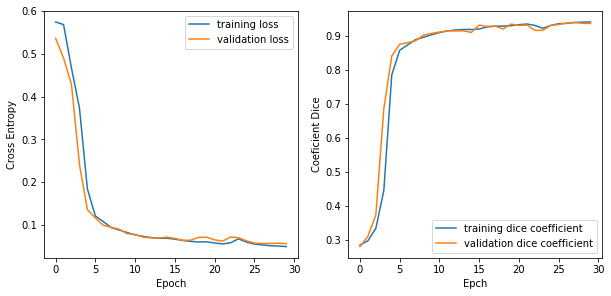

In [16]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epch")
    plt.ylabel("Coeficient Dice")
    
get_metrics(history = history)